### Задание 2

Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные [здесь](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/spam.csv)) по признаку спама. Для этого:

1. Привидите весь текст к нижнему регистру;
2. Удалите мусорные символы;
3. Удалите стоп-слова;
4. Привидите все слова к нормальной форме;
5. Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:

```
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)
```

Можете поэкспериментировать с параметрами [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html);

6. Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите `random_state=42`. Используйте [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html);
7. Постройте модель [логистической регрессии](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), укажите `random_state=42`, оцените ее точность на тестовых данных;
8. Опишите результаты при помощи [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix);
9. Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).


In [1]:
import lzma
import pandas as pd

file = lzma.open('data/spam.csv.xz')
texts = pd.read_csv(file)

In [2]:
texts.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/kolt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kolt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_set = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

to_lower = lambda x: x.lower()
only_word_characters = lambda x: re.sub('[\W_]+', ' ', x)
to_words = lambda x: x.split()
skip_stopword = lambda x: [word for word in x if word not in stopwords_set ]
lemmatize = lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x]
to_sentence = lambda x: ' '.join(x)


texts['Proccessed'] = (texts['Message']
                    .apply(to_lower)
                    .apply(only_word_characters)
                    .apply(to_words)
                    .apply(skip_stopword)
                    .apply(lemmatize)
                    .apply(to_sentence)
                   )
texts.head()

,Category,Message,Proccessed
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(texts['Proccessed'])
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)

In [6]:
from sklearn.model_selection import train_test_split

data = tfidf_matrix
data_class = texts['Category']

X_train, X_test, y_train, y_test = train_test_split(data, data_class, test_size=0.30, random_state=42)

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.958732057416268

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1445,    3],
       [  66,  158]])

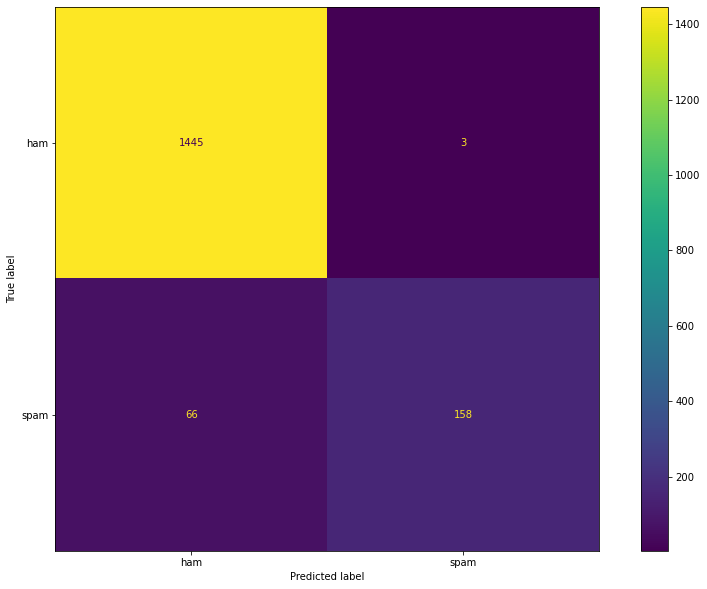

In [10]:
from sklearn.metrics import plot_confusion_matrix
from pylab import rcParams

rcParams['figure.figsize'] = 15,10

ax = plot_confusion_matrix(lr, X_test, y_test)

In [11]:
predicted_df = pd.DataFrame(y_pred, index=X_test.index, columns=['Category (predicted)'])
predicted_texts = predicted_df.join(texts)
predicted_texts.head()

,Category (predicted),Category,Message,Proccessed
3245,ham,ham,Squeeeeeze!! This is christmas hug.. If u lik ...,squeeeeeze christmas hug u lik frndshp den hug...
944,ham,ham,And also I've sorta blown him off a couple tim...,also sorta blown couple time recently id rathe...
1044,ham,ham,Mmm thats better now i got a roast down me! i...,mmm thats better got roast b better drink 2 go...
2484,ham,ham,Mm have some kanji dont eat anything heavy ok,mm kanji dont eat anything heavy ok
812,ham,ham,So there's a ring that comes with the guys cos...,ring come guy costume gift future yowifes hint...


In [12]:
differ = predicted_texts['Category (predicted)'] != predicted_texts['Category']
predicted_texts[differ]

,Category (predicted),Category,Message,Proccessed
2952,spam,ham,Hey now am free you can call me.,hey free call
881,ham,spam,Reminder: You have not downloaded the content ...,reminder downloaded content already paid goto ...
1961,ham,spam,Guess what! Somebody you know secretly fancies...,guess somebody know secretly fancy wanna find ...
3864,ham,spam,Oh my god! I've found your number again! I'm s...,oh god found number glad text back xafter msg ...
2575,ham,spam,Your next amazing xxx PICSFREE1 video will be ...,next amazing xxx picsfree1 video sent enjoy on...
...,...,...,...,...
4543,ham,spam,FreeMsg Hi baby wow just got a new cam moby. W...,freemsg hi baby wow got new cam moby wanna c h...
752,ham,spam,You have an important customer service announc...,important customer service announcement premier
309,ham,spam,TheMob> Check out our newest selection of cont...,themob check newest selection content game ton...
495,spam,ham,Are you free now?can i call now?,free call
